# sample genes- scvelo

In [8]:
# modified form https://github.com/GuangyuWangLab2021/veloNN/blob/main/tests/scanpy_th9_velocyto.py
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import anndata
srcdir = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/src'

sys.path.append(srcdir)
from celldancer.sampling import sampling_neighbors
from celldancer.cdplt import colormap
import celldancer.cdplt as cdplt
import os
import math

In [17]:
def pipline_run_sim_data(load_raw_data):

    # unsplice&splice
    splice_mat=load_raw_data.pivot(index='gene_name', values='splice', columns='cellID')
    unsplice_mat=load_raw_data.pivot(index='gene_name', values='unsplice', columns='cellID')

    one_gene_raw=load_raw_data[load_raw_data.gene_name==list(load_raw_data.gene_name)[0]]

    cols=one_gene_raw['cellID']
    splice_mat = splice_mat[cols].T
    unsplice_mat = unsplice_mat[cols].T
    splice_mat.to_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/scvelo_predict_result/build_scv_compatible_raw/splice.csv')
    unsplice_mat.to_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/scvelo_predict_result/build_scv_compatible_raw/unsplice.csv')

    splice_mat=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/scvelo_predict_result/build_scv_compatible_raw/splice.csv')
    unsplice_mat=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/scvelo_predict_result/build_scv_compatible_raw/unsplice.csv')

    adata_building=sc.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/scvelo_predict_result/build_scv_compatible_raw/splice.csv', delimiter=',', first_column_names=True, dtype='float32')
    adata_building.layers['Ms']=splice_mat.to_numpy()[:,1:]
    adata_building.layers['Mu']=unsplice_mat.to_numpy()[:,1:]

    adata_building.layers['Ms']=np.array(adata_building.layers['Ms'], dtype=float)
    adata_building.layers['Mu']=np.array(adata_building.layers['Mu'], dtype=float)

    adata_building_test=adata_building.copy()
    # adata_building_test2=adata_building.copy()

    # velocity
    # scv.pp.moments(adata_building_test, n_pcs=30, n_neighbors=30)
    # scv.pp.moments(adata_building_test, n_pcs=50, n_neighbors=50)

    # steady_state_velocity
    scv.tl.velocity(adata_building_test, vkey='steady_state_velocity', mode='steady_state')
    scv.tl.velocity_graph(adata_building_test, vkey='steady_state_velocity')

    # dynamical_velocity
    scv.tl.recover_dynamics(adata_building_test, n_jobs=30, n_top_genes = 1000)
    scv.tl.velocity(adata_building_test, vkey='dynamical_velocity',mode='dynamical',filter_genes=False)
    
    # plot - steady_state_velocity
    gene_choice=load_raw_data['gene_name'].drop_duplicates()

    for gene in list(gene_choice)[0:3]:
        scv.pl.velocity_embedding(adata_building_test, vkey='steady_state_velocity', basis=gene,
                            scale=.6, width=.0035, frameon=False, title=gene,show=False)
        # plot- dynamical_velocity
        scv.pl.velocity_embedding(adata_building_test, vkey='dynamical_velocity', basis=gene, scale=4, width=.0035,
                            frameon=False, title=gene,show=False)
        
    adata_building_test.write(filename='/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/scvelo_predict_result/build_scv_compatible_raw/neuro.h5ad')

    # gene velocity plot
    gene_choice=load_raw_data['gene_name'].drop_duplicates()
    # gene_choice=['simulation0','simulation1']

    outpath='/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/scvelo_predict_result/velocity_result'
    gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df=pd.DataFrame()
    for nth,gene in enumerate(gene_choice):
        if nth % 100 ==0: print(nth)
        # dynamical_velocity
        outpath='/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/scvelo_predict_result/velocity_result'
        save_path=os.path.join(outpath,'scvelo_result',('multi_path_'),(gene+'_dynamic.pdf'))
        X, V=scv.pl.velocity_embedding(adata_building_test, vkey='dynamical_velocity', basis=gene,
                            fontsize=16, frameon=False,show=False)
        splice_unsplice_splice_predict_unsplice_predict=np.concatenate((X, V), axis=1)

        # steady_state_velocity
        save_path=os.path.join(outpath,'scvelo_result',('multi_path_'),(gene+'_static.pdf'))
        X_steady, V_steady=scv.pl.velocity_embedding(adata_building_test, vkey='steady_state_velocity', basis=gene,
                          scale=.6, width=.0035, frameon=False,show=False)
        splice_unsplice_splice_predict_unsplice_predict_steady=np.concatenate((X_steady, V_steady), axis=1)

        one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady=np.hstack((splice_unsplice_splice_predict_unsplice_predict,splice_unsplice_splice_predict_unsplice_predict_steady))
        one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df = pd.DataFrame(one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady, columns = ['dynamic_splice','dynamic_unsplice','dynamic_splice_predict','dynamic_unsplice_predict','static_splice','static_unsplice','static_splice_predict','static_unsplice_predict'])
        one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df.insert (0, "gene_name", gene)
        gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df = pd.concat([gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df,one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df])
        
    gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df.to_csv(os.path.join(outpath,'scvelo_result_multi_path__splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df_neuro.csv'),index=False)

In [14]:
load_raw_data=pd.read_csv('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/DentateGyrus.csv')


gene_list=['Klf7','Syt11','Gnao1','Dcx','Dctn3',
           'Gpm6b','Ptpro','Psd3','Ntrk2','Ncald',
           'Slc1a3','Astn1','Evl','Tbc1d16','Cadm1']

load_raw_data=load_raw_data[load_raw_data.gene_name.isin(gene_list)]

In [16]:
load_raw_data

,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
417220,Klf7,0.408467,1.294797,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
417221,Klf7,0.379136,1.256870,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
417222,Klf7,0.893599,3.395004,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
417223,Klf7,0.640505,2.739187,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
417224,Klf7,0.662303,2.433943,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...
39164255,Gpm6b,0.876650,1.276089,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
39164256,Gpm6b,2.024897,5.152006,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
39164257,Gpm6b,1.848051,1.491445,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
39164258,Gpm6b,0.696361,1.189091,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


computing velocities
    finished (0:00:00) --> added 
    'steady_state_velocity', velocity vectors for each individual cell (adata.layers)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:20) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/18140 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'steady_state_velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 16/16 cores)
19.587514611229174
28.89478532771115
[0.07141172 0.0978322  0.04450894 ... 6.4123866  0.09973166 0.09450988]
[1.29682070e-04 2.43542216e-04 5.03455699e-05 ... 1.23996210e+00
 2.53102337e-04 2.27264241e-04]
[1.04035830e-03 1.73514277e-03 4.82648110e-04 ... 1.73205702e+00
 1.79022516e-03 1.64040231e-03]
[ 0.18334284  0.25043405  0.11467364 ... 13.42528884  0.25524549
  0.2420147 ]
[0.07141172 0.0978322  0.04450894 ... 6.4123866  0.09973166 0.09450988]
[1.29682070e-04 2.43542216e-04 5.03455699e-05 ... 1.23996210e+00
 2.53102337e-04 2.27264241e-04]
[1.04035830e-03 1.73514277e-03 4.82648110e-04 ... 1.73205702e+00
 1.79022516e-03 9.17757717e+00]
[ 0.18334284  0.25043405  0.11467364 ... 13.42528884  0.25524549
 26.19148869]
19.587514611229174
28.89478532771115
[0.07141172 0.0978322  0.04450894 ... 6.4123866  0.09973166 0.09450988]
[1.2

TypeError: cannot unpack non-iterable AxesSubplot object

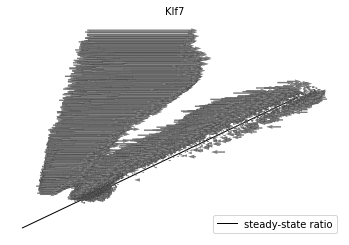

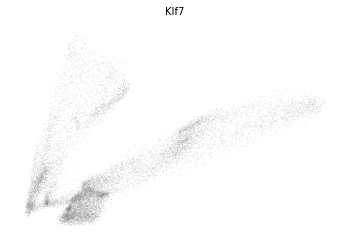

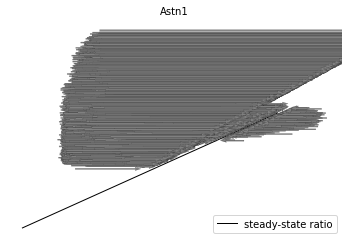

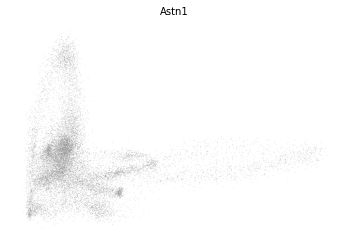

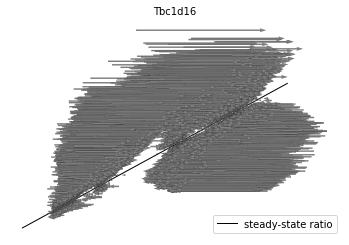

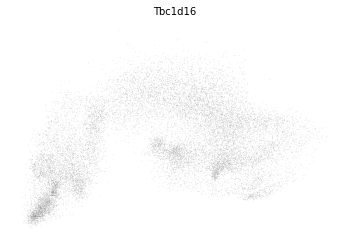

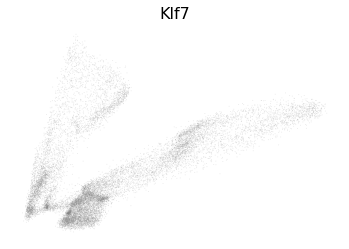


[5.47689123e-01 6.10764637e-01 1.36528295e-02 ... 9.59386208e-04
 1.24520268e+00 1.35562778e+00]
[0.64736648 0.69044596 0.05991212 ... 0.01010096 1.02103284 1.06282538]
[1.30721636 1.32696782 0.4217411  ... 0.13574126 1.39294738 1.39252461]
[0.84455889 0.87639035 0.16586212 ... 0.04509373 1.05939109 1.07240473]
[5.47689123e-01 6.10764637e-01 1.36528295e-02 ... 9.59386208e-04
 1.24520268e+00 1.35562778e+00]
[0.64736648 0.69044596 0.05991212 ... 0.01010096 1.02103284 1.06282538]
[1.30721636 1.32696782 0.4217411  ... 0.13574126 1.39294738 1.39252461]
[0.64736648 0.69044596 0.16586212 ... 0.04509373 1.02103284 1.07240473]
[1.30721636e+00 1.32696782e+00 1.36528295e-02 ... 9.59386208e-04
 1.39294738e+00 1.35562778e+00]
1.0754715609446794
1.3920715328496762
[0.84455889 0.87639035 0.16586212 ... 0.04509373 1.05939109 1.07240473]
[5.47689123e-01 6.10764637e-01 1.36528295e-02 ... 9.59386208e-04
 1.24520268e+00 1.35562778e+00]
[0.64736648 0.69044596 0.05991212 ... 0.01010096 1.02103284 1.0628253

In [18]:

pipline_run_sim_data(load_raw_data)
        

# plot

static


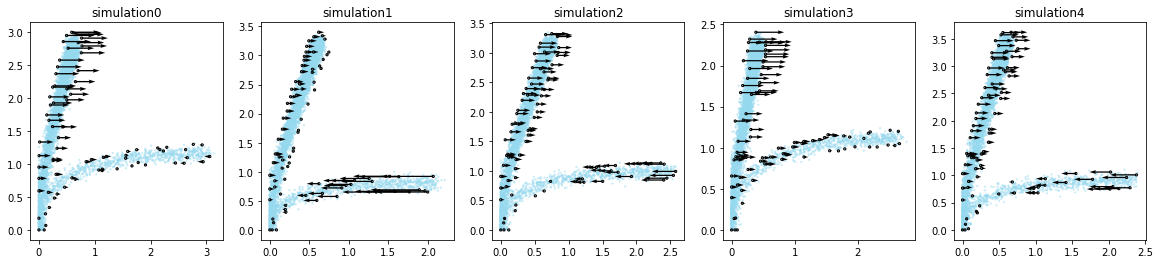

dynamic


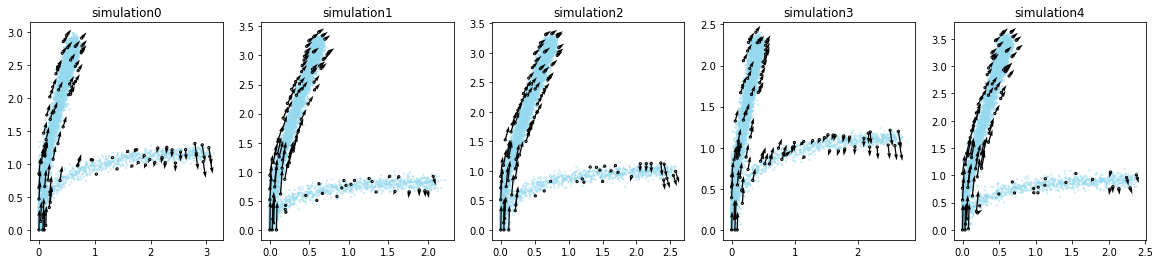

In [34]:
import pandas as pd

scv_result=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/multi_path_new/velocity_result/scv/scvelo_result_multi_path__splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df_0.2.csv')    

splice_unsplice_splice_predict_unsplice_predict_dynamic=scv_result[['gene_name','dynamic_splice','dynamic_unsplice','dynamic_splice_predict','dynamic_unsplice_predict']]
splice_unsplice_splice_predict_unsplice_predict_static=scv_result[['gene_name','static_splice','static_unsplice','static_splice_predict','static_unsplice_predict']]
splice_unsplice_splice_predict_unsplice_predict_dynamic=splice_unsplice_splice_predict_unsplice_predict_dynamic.rename(columns={'gene_name': 'gene_name', 'dynamic_splice': 'splice', 'dynamic_unsplice': 'unsplice', 'dynamic_splice_predict': 'splice_predict', 'dynamic_unsplice_predict': 'unsplice_predict'})
splice_unsplice_splice_predict_unsplice_predict_static=splice_unsplice_splice_predict_unsplice_predict_static.rename(columns={'gene_name': 'gene_name', 'static_splice': 'splice', 'static_unsplice': 'unsplice', 'static_splice_predict': 'splice_predict', 'static_unsplice_predict': 'unsplice_predict'})

splice_unsplice_splice_predict_unsplice_predict_dynamic.splice_predict=splice_unsplice_splice_predict_unsplice_predict_dynamic.splice+splice_unsplice_splice_predict_unsplice_predict_dynamic.splice_predict
splice_unsplice_splice_predict_unsplice_predict_dynamic.unsplice_predict=splice_unsplice_splice_predict_unsplice_predict_dynamic.unsplice+splice_unsplice_splice_predict_unsplice_predict_dynamic.unsplice_predict

splice_unsplice_splice_predict_unsplice_predict_static.splice_predict=splice_unsplice_splice_predict_unsplice_predict_static.splice+splice_unsplice_splice_predict_unsplice_predict_static.splice_predict
splice_unsplice_splice_predict_unsplice_predict_static.unsplice_predict=splice_unsplice_splice_predict_unsplice_predict_static.unsplice+splice_unsplice_splice_predict_unsplice_predict_static.unsplice_predict

print('static')
import math
gene_list=list(splice_unsplice_splice_predict_unsplice_predict_static.gene_name.drop_duplicates())[0:5]

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=splice_unsplice_splice_predict_unsplice_predict_static,
        custom_xlim=None,
        custom_ylim=None,
        colors=None,
        alpha=0.5, 
        s = 5,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    # ax.axis('off')

plt.show()

print('dynamic')
import math
gene_list=list(splice_unsplice_splice_predict_unsplice_predict_dynamic.gene_name.drop_duplicates())[0:5]

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=splice_unsplice_splice_predict_unsplice_predict_dynamic,
        custom_xlim=None,
        custom_ylim=None,
        colors=None,
        alpha=0.5, 
        s = 5,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    # ax.axis('off')

plt.show()